In [1]:
from __future__ import print_function, division, unicode_literals
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch import distributions as pyd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [9]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)

class RewardNetFeature(nn.Module):
    def __init__(
        self, feature_dim, output_mod=None):
        super().__init__()
        self.feature1 = nn.Sequential(
            nn.Linear(feature_dim, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.feature2 = nn.Sequential(
            nn.Linear(feature_dim, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.feature3 = nn.Sequential(
            nn.Linear(feature_dim, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.feature4 = nn.Sequential(
            nn.Linear(feature_dim, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.feature5 = nn.Sequential(
            nn.Linear(feature_dim, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.feature6 = nn.Sequential(
            nn.Linear(feature_dim, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.pref_feature1 = nn.Linear(2,1)
        self.pref_feature2 = nn.Linear(2,1)
        self.pref_feature3 = nn.Linear(2,1)
        self.pref_feature4 = nn.Linear(2,1)
        self.pref_feature5 = nn.Linear(2,1)
        self.pref_feature6 = nn.Linear(2,1)
        self.pref = nn.Linear(6, 1)
        self.apply(weight_init)

    def forward(self, feature1a, feature1b, feature2a, feature2b, feature3a, feature3b, 
                feature4a, feature4b, feature5a, feature5b, feature6a, feature6b, state1, state2):
        feature1a = self.feature1(feature1a)
        feature1b = self.feature1(feature1b)
        feature2a = self.feature2(feature2a)
        feature2b = self.feature2(feature2b)
        feature3a = self.feature3(feature3a)
        feature3b = self.feature3(feature3b)
        feature4a = self.feature4(feature4a)
        feature4b = self.feature4(feature4b)
        feature5a = self.feature5(feature5a)
        feature5b = self.feature5(feature5b)
        feature6a = self.feature6(feature6a)
        feature6b = self.feature6(feature6b)
        pref_feature1 = self.pref_feature1(torch.squeeze(torch.stack([feature1a,feature1b], dim=1)))
        pref_feature2 = self.pref_feature2(torch.squeeze(torch.stack([feature2a,feature2b], dim=1)))
        pref_feature3 = self.pref_feature3(torch.squeeze(torch.stack([feature3a,feature3b], dim=1)))
        pref_feature4 = self.pref_feature4(torch.squeeze(torch.stack([feature4a,feature4b], dim=1)))
        pref_feature5 = self.pref_feature5(torch.squeeze(torch.stack([feature5a,feature5b], dim=1)))
        pref_feature6 = self.pref_feature6(torch.squeeze(torch.stack([feature6a,feature6b], dim=1)))
        pref = self.pref(torch.squeeze(torch.stack([pref_feature1, pref_feature2, pref_feature3, 
                                                    pref_feature4, pref_feature5, pref_feature6], dim=1)))
        return pref_feature1, pref_feature2, pref_feature3, pref_feature4, pref_feature5, pref_feature6, pref

In [10]:
feature_dim = 3

reward_net = RewardNetFeature(feature_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reward_net.to(device)

RewardNetFeature(
  (feature1): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (feature2): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (feature3): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (feature4): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (feature5): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (feature6): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  

In [11]:
import csv
with open('data/train_rewards10.csv') as file_obj:
    reader_obj = csv.reader(file_obj)

    states1, states2, prefs = [], [], []
    features1a, features1b, prefs_feature1 = [], [], []
    features2a, features2b, prefs_feature2 = [], [], []
    features3a, features3b, prefs_feature3 = [], [], []
    features4a, features4b, prefs_feature4 = [], [], []
    features5a, features5b, prefs_feature5 = [], [], []
    features6a, features6b, prefs_feature6 = [], [], []
    for row in reader_obj:
        states1.append(row[0:18])
        states2.append(row[19:37])
        prefs.append(row[38])
        features1a.append(row[0:3])
        features1b.append(row[19:22])
        prefs_feature1.append(row[39])
        features2a.append(row[3:6])
        features2b.append(row[22:25])
        prefs_feature2.append(row[40])
        features3a.append(row[6:9])
        features3b.append(row[25:28])
        prefs_feature3.append(row[41])
        features4a.append(row[9:12])
        features4b.append(row[28:31])
        prefs_feature4.append(row[42])
        features5a.append(row[12:15])
        features5b.append(row[31:34])
        prefs_feature5.append(row[43])
        features6a.append(row[15:18])
        features6b.append(row[34:37])
        prefs_feature6.append(row[44])
    states1 = np.array(states1,dtype=int)
    states2 = np.array(states2,dtype=int)
    prefs = np.array(prefs,dtype=int)
    features1a = np.array(features1a,dtype=int)
    features1b = np.array(features1b,dtype=int)
    prefs_feature1 = np.array(prefs_feature1,dtype=int)
    features2a = np.array(features2a,dtype=int)
    features2b = np.array(features2b,dtype=int)
    prefs_feature2 = np.array(prefs_feature2,dtype=int)
    features3a = np.array(features3a,dtype=int)
    features3b = np.array(features3b,dtype=int)
    prefs_feature3 = np.array(prefs_feature3,dtype=int)
    features4a = np.array(features4a,dtype=int)
    features4b = np.array(features4b,dtype=int)
    prefs_feature4 = np.array(prefs_feature4,dtype=int)
    features5a = np.array(features5a,dtype=int)
    features5b = np.array(features5b,dtype=int)
    prefs_feature5 = np.array(prefs_feature5,dtype=int)
    features6a = np.array(features6a,dtype=int)
    features6b = np.array(features6b,dtype=int)
    prefs_feature6 = np.array(prefs_feature6,dtype=int)

[1,     1] loss: 4.77241802
[2,     1] loss: 4.75228357
[3,     1] loss: 4.73231936
[4,     1] loss: 4.71244621
[5,     1] loss: 4.69266176
[6,     1] loss: 4.67298365
[7,     1] loss: 4.65344524
[8,     1] loss: 4.63398361
[9,     1] loss: 4.61454630
[10,     1] loss: 4.59521770
[11,     1] loss: 4.57599211
[12,     1] loss: 4.55684519
[13,     1] loss: 4.53776884
[14,     1] loss: 4.51880026
[15,     1] loss: 4.49995661
[16,     1] loss: 4.48123312
[17,     1] loss: 4.46262836
[18,     1] loss: 4.44414663
[19,     1] loss: 4.42571688
[20,     1] loss: 4.40727901
[21,     1] loss: 4.38894606
[22,     1] loss: 4.37074709
[23,     1] loss: 4.35263062
[24,     1] loss: 4.33457470
[25,     1] loss: 4.31657076
[26,     1] loss: 4.29856777
[27,     1] loss: 4.28058672
[28,     1] loss: 4.26264334
[29,     1] loss: 4.24471855
[30,     1] loss: 4.22681475
[31,     1] loss: 4.20893717
[32,     1] loss: 4.19110680
[33,     1] loss: 4.17330313
[34,     1] loss: 4.15559101
[35,     1] loss: 4.137

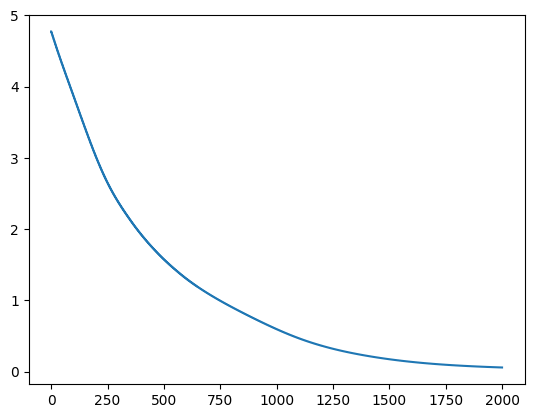

In [12]:
num_epochs = 1000
batch_size = 10

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(list(reward_net.parameters()), lr=0.001)

losses = []

idxs = np.array(range(len(states1)))
num_batches = len(idxs) // batch_size

# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()
   
        t_states1 = torch.Tensor(states1).float().to(device)
        t_states2 = torch.Tensor(states2).float().to(device)
        t_prefs = torch.Tensor(prefs).float().to(device).unsqueeze(1)
        t_features1a = torch.Tensor(features1a).float().to(device)
        t_features1b = torch.Tensor(features1b).float().to(device)
        t_prefs_feature1 = torch.Tensor(prefs_feature1).float().to(device).unsqueeze(1)
        t_features2a = torch.Tensor(features2a).float().to(device)
        t_features2b = torch.Tensor(features2b).float().to(device)
        t_prefs_feature2 = torch.Tensor(prefs_feature2).float().to(device).unsqueeze(1)
        t_features3a = torch.Tensor(features3a).float().to(device)
        t_features3b = torch.Tensor(features3b).float().to(device)
        t_prefs_feature3 = torch.Tensor(prefs_feature3).float().to(device).unsqueeze(1)
        t_features4a = torch.Tensor(features4a).float().to(device)
        t_features4b = torch.Tensor(features4b).float().to(device)
        t_prefs_feature4 = torch.Tensor(prefs_feature4).float().to(device).unsqueeze(1)
        t_features5a = torch.Tensor(features5a).float().to(device)
        t_features5b = torch.Tensor(features5b).float().to(device)
        t_prefs_feature5 = torch.Tensor(prefs_feature5).float().to(device).unsqueeze(1)
        t_features6a = torch.Tensor(features6a).float().to(device)
        t_features6b = torch.Tensor(features6b).float().to(device)
        t_prefs_feature6 = torch.Tensor(prefs_feature6).float().to(device).unsqueeze(1)
        pred_prefs_feature1, pred_prefs_feature2, pred_prefs_feature3, pred_prefs_feature4, pred_prefs_feature5, pred_prefs_feature6, pred_prefs = reward_net(t_features1a, t_features1b, t_features2a, t_features2b, t_features3a, t_features3b, 
                                                                                                                           t_features4a, t_features4b, t_features5a, t_features5b, t_features6a, t_features6b, 
                                                                                                                           t_states1, t_states2)
        feature1_loss = criterion(pred_prefs_feature1, t_prefs_feature1)
        feature2_loss = criterion(pred_prefs_feature2, t_prefs_feature2)
        feature3_loss = criterion(pred_prefs_feature3, t_prefs_feature3)
        feature4_loss = criterion(pred_prefs_feature4, t_prefs_feature4)
        feature5_loss = criterion(pred_prefs_feature5, t_prefs_feature5)
        feature6_loss = criterion(pred_prefs_feature6, t_prefs_feature6)
        state_loss = criterion(pred_prefs, t_prefs)
        loss = feature1_loss + feature2_loss + feature3_loss + feature4_loss + feature5_loss + feature6_loss + state_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss))
            losses.append(running_loss)
            running_loss = 0.0
        losses.append(loss.item())

torch.save(reward_net, 'reward_network.pt')
print('Finished Training')
plt.plot(losses)
plt.savefig('losses.png')

In [13]:
reward_net = torch.load('reward_network.pt')
reward_net.eval()

import csv
with open('data/test_rewards.csv') as file_obj:
    reader_obj = csv.reader(file_obj)

    states1, states2, prefs = [], [], []
    features1a, features1b, prefs_feature1 = [], [], []
    features2a, features2b, prefs_feature2 = [], [], []
    features3a, features3b, prefs_feature3 = [], [], []
    features4a, features4b, prefs_feature4 = [], [], []
    features5a, features5b, prefs_feature5 = [], [], []
    features6a, features6b, prefs_feature6 = [], [], []
    for row in reader_obj:
        states1.append(row[0:18])
        states2.append(row[19:37])
        prefs.append(row[38])
        features1a.append(row[0:3])
        features1b.append(row[19:22])
        prefs_feature1.append(row[39])
        features2a.append(row[3:6])
        features2b.append(row[22:25])
        prefs_feature2.append(row[40])
        features3a.append(row[6:9])
        features3b.append(row[25:28])
        prefs_feature3.append(row[41])
        features4a.append(row[9:12])
        features4b.append(row[28:31])
        prefs_feature4.append(row[42])
        features5a.append(row[12:15])
        features5b.append(row[31:34])
        prefs_feature5.append(row[43])
        features6a.append(row[15:18])
        features6b.append(row[34:37])
        prefs_feature6.append(row[44])
    states1 = np.array(states1,dtype=int)
    states2 = np.array(states2,dtype=int)
    prefs = np.array(prefs,dtype=int)
    features1a = np.array(features1a,dtype=int)
    features1b = np.array(features1b,dtype=int)
    prefs_feature1 = np.array(prefs_feature1,dtype=int)
    features2a = np.array(features2a,dtype=int)
    features2b = np.array(features2b,dtype=int)
    prefs_feature2 = np.array(prefs_feature2,dtype=int)
    features3a = np.array(features3a,dtype=int)
    features3b = np.array(features3b,dtype=int)
    prefs_feature3 = np.array(prefs_feature3,dtype=int)
    features4a = np.array(features4a,dtype=int)
    features4b = np.array(features4b,dtype=int)
    prefs_feature4 = np.array(prefs_feature4,dtype=int)
    features5a = np.array(features5a,dtype=int)
    features5b = np.array(features5b,dtype=int)
    prefs_feature5 = np.array(prefs_feature5,dtype=int)
    features6a = np.array(features6a,dtype=int)
    features6b = np.array(features6b,dtype=int)
    prefs_feature6 = np.array(prefs_feature6,dtype=int)

num_correct = 0.0
for i in range(len(states1)):
    state1 = torch.Tensor(states1[i]).to(device)
    state2 = torch.Tensor(states2[i]).to(device)
    feature1a = torch.Tensor(features1a[i]).to(device)
    feature1b = torch.Tensor(features1b[i]).to(device)
    feature2a = torch.Tensor(features2a[i]).to(device)
    feature2b = torch.Tensor(features2b[i]).to(device)
    feature3a = torch.Tensor(features3a[i]).to(device)
    feature3b = torch.Tensor(features3b[i]).to(device)
    feature4a = torch.Tensor(features4a[i]).to(device)
    feature4b = torch.Tensor(features4b[i]).to(device)
    feature5a = torch.Tensor(features5a[i]).to(device)
    feature5b = torch.Tensor(features5b[i]).to(device)
    feature6a = torch.Tensor(features6a[i]).to(device)
    feature6b = torch.Tensor(features6b[i]).to(device)
    pref_feature1, pref_feature2, pref_feature3, pref_feature4, pref_feature5, pref_feature6, pred_pref = reward_net(feature1a, feature1b, feature2a, feature2b, feature3a, feature3b, 
                                                                                                                feature4a, feature4b, feature5a, feature5b, feature6a, feature6b, 
                                                                                                                state1, state2)
    pred_pref = torch.sigmoid(pred_pref).cpu().detach().numpy()[0]
    if pred_pref > 0.5 and prefs[i] == 1:
        num_correct+=1
    elif pred_pref <= 0.5 and prefs[i] == 0:
        num_correct+=1

accuracy = num_correct / len(states1)
print("Percent correct: %f " % accuracy)

Percent correct: 0.900000 
